In [2]:
!pip install torch -q

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")

PyTorch: 2.9.0+cpu
NumPy: 2.0.2


In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('data.csv', encoding='latin1', low_memory=False)
x  = df['no2'].dropna().values
x  = x[(x > 0) & (x < np.percentile(x, 99))].astype(np.float32)
del df

print(f"NO2 samples: {len(x)}")
print(f"Min: {x.min():.4f}, Max: {x.max():.4f}, Mean: {x.mean():.4f}")

Saving data.csv to data.csv
NO2 samples: 414525
Min: 0.2000, Max: 93.4000, Mean: 24.8673


In [4]:
r   = 102303335
a_r = 0.05 * (r % 7)
b_r = 0.3  * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)

print(f"a_r = {a_r}, b_r = {b_r}")
print(f"z mean={z.mean():.4f}, std={z.std():.4f}")

a_r = 0.05, b_r = 0.3
z mean=24.8656, std=15.1037


In [5]:
z_mean = z.mean()
z_std  = z.std()
z_norm = (z - z_mean) / z_std

z_tensor = torch.FloatTensor(z_norm).unsqueeze(1)

print(f"Normalized mean={z_norm.mean():.4f}, std={z_norm.std():.4f}")
print(f"Tensor shape: {z_tensor.shape}")

Normalized mean=0.0000, std=1.0000
Tensor shape: torch.Size([414525, 1])


In [6]:

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),  nn.LeakyReLU(0.2),
            nn.Linear(32, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 32), nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),  nn.LeakyReLU(0.2),
            nn.Linear(32, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 32), nn.LeakyReLU(0.2),
            nn.Linear(32, 1),  nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

G = Generator()
D = Discriminator()

print("Generator:")
print(G)
print("\nDiscriminator:")
print(D)

Generator:
Generator(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

Discriminator:
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [7]:

EPOCHS     = 2000
BATCH_SIZE = 256
LR         = 0.0002

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

G_losses, D_losses = [], []

print(f"Epochs: {EPOCHS}, Batch: {BATCH_SIZE}, LR: {LR}")

Epochs: 2000, Batch: 256, LR: 0.0002


In [8]:
torch.manual_seed(42)
np.random.seed(42)
n_samples = len(z_tensor)

for epoch in range(EPOCHS):
    idx         = np.random.randint(0, n_samples, BATCH_SIZE)
    real_data   = z_tensor[idx]
    real_labels = torch.ones(BATCH_SIZE, 1)
    fake_labels = torch.zeros(BATCH_SIZE, 1)

    opt_D.zero_grad()
    loss_real = criterion(D(real_data), real_labels)
    loss_fake = criterion(D(G(torch.randn(BATCH_SIZE, 1)).detach()), fake_labels)
    loss_D    = loss_real + loss_fake
    loss_D.backward()
    opt_D.step()

    opt_G.zero_grad()
    loss_G = criterion(D(G(torch.randn(BATCH_SIZE, 1))), real_labels)
    loss_G.backward()
    opt_G.step()

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | D: {loss_D.item():.4f} | G: {loss_G.item():.4f}")

print("Training complete!")

Epoch 500/2000 | D: 1.3885 | G: 0.6850
Epoch 1000/2000 | D: 1.3860 | G: 0.6941
Epoch 1500/2000 | D: 1.3880 | G: 0.6919
Epoch 2000/2000 | D: 1.3867 | G: 0.6941
Training complete!


In [9]:
G.eval()

with torch.no_grad():
    fake_norm = G(torch.randn(10000, 1)).squeeze().numpy()

fake_z      = fake_norm * z_std + z_mean
real_sample = np.random.choice(z, size=5000, replace=False)

print(f"Fake z - Mean: {fake_z.mean():.4f}, Std: {fake_z.std():.4f}")
print(f"Real z - Mean: {real_sample.mean():.4f}, Std: {real_sample.std():.4f}")

Fake z - Mean: 26.5654, Std: 16.0592
Real z - Mean: 24.7409, Std: 15.0490


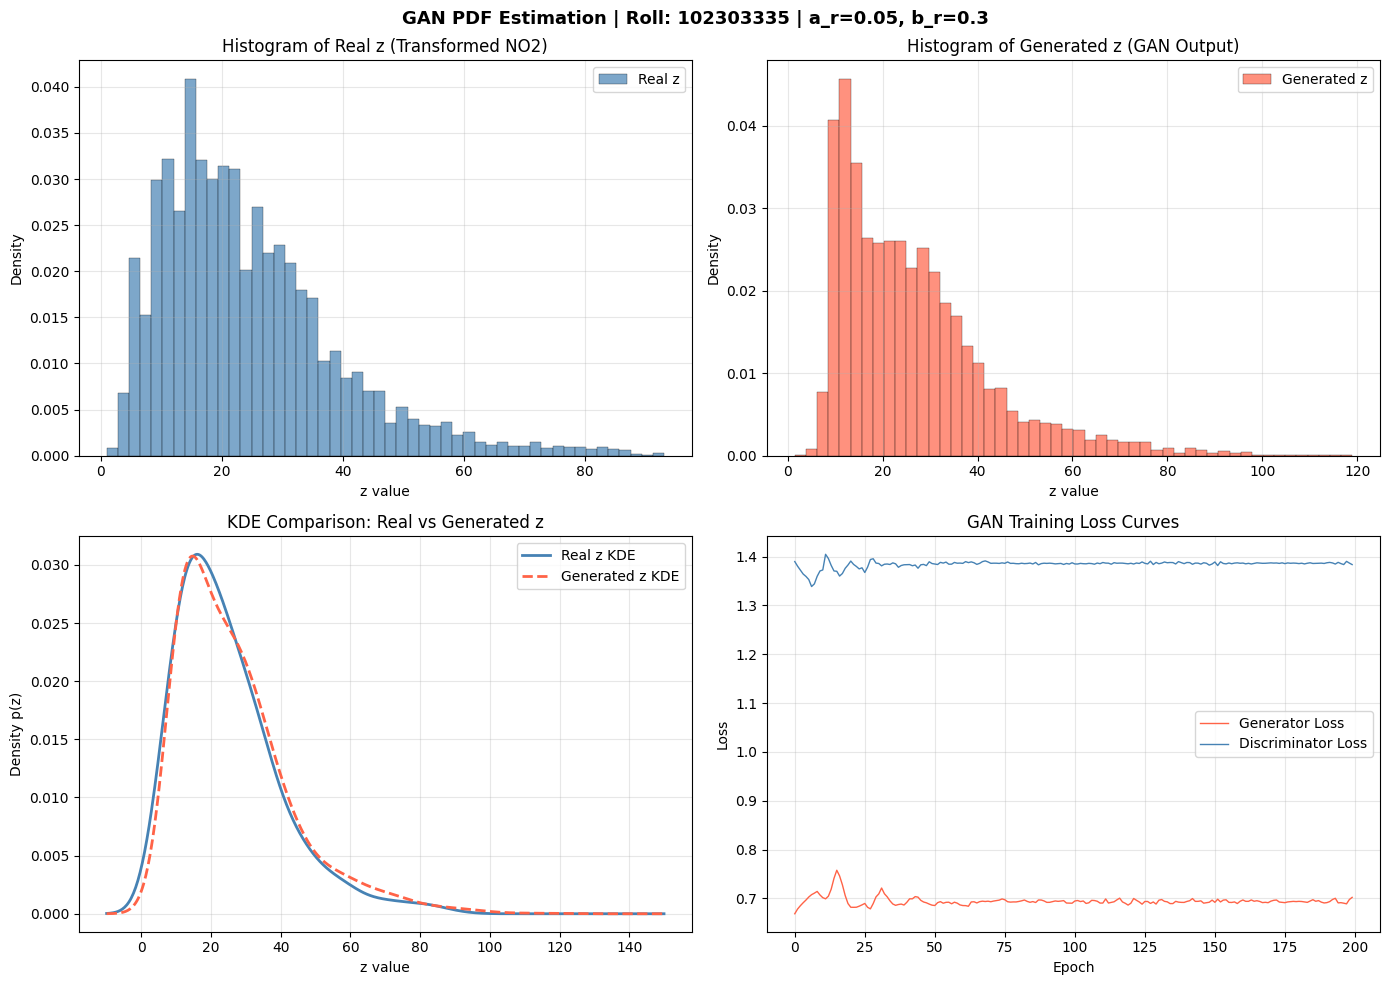

Done!


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'GAN PDF Estimation | Roll: 102303335 | a_r={a_r}, b_r={b_r}', fontsize=13, fontweight='bold')

axes[0, 0].hist(real_sample, bins=50, density=True, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.3)
axes[0, 0].set_title('Histogram of Real z (Transformed NO2)')
axes[0, 0].set_xlabel('z value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend(['Real z'])
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(fake_z, bins=50, density=True, color='tomato', alpha=0.7, edgecolor='black', linewidth=0.3)
axes[0, 1].set_title('Histogram of Generated z (GAN Output)')
axes[0, 1].set_xlabel('z value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend(['Generated z'])
axes[0, 1].grid(True, alpha=0.3)

z_range  = np.linspace(-10, 150, 500)
kde_real = gaussian_kde(real_sample, bw_method=0.3)
kde_fake = gaussian_kde(fake_z, bw_method=0.3)
axes[1, 0].plot(z_range, kde_real(z_range), color='steelblue', linewidth=2, label='Real z KDE')
axes[1, 0].plot(z_range, kde_fake(z_range), color='tomato', linewidth=2, label='Generated z KDE', linestyle='--')
axes[1, 0].set_title('KDE Comparison: Real vs Generated z')
axes[1, 0].set_xlabel('z value')
axes[1, 0].set_ylabel('Density p(z)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(G_losses[::10], color='tomato', linewidth=1, label='Generator Loss')
axes[1, 1].plot(D_losses[::10], color='steelblue', linewidth=1, label='Discriminator Loss')
axes[1, 1].set_title('GAN Training Loss Curves')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gan_pdf_results.png', dpi=100, bbox_inches='tight')
plt.show()
print("Done!")